In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder

In [2]:
#constants
n_jobs = -1
random_state = 42
seed = 24

### Import Data Set

In [3]:
df = pd.read_csv('df_for_model.csv') #from 'Machine Learning - Preparation'
random_sample = df.sample(n=1000, random_state=random_state) #for validation
df = df.drop(random_sample.index)

In [4]:
df.head()

,DepDelay,Month,route,TaxiOut,TaxiIn,TimeDifferenceMinutes_wheels,Distance,ArrDelay
0,-3.0,12,LGA-DEN,38.0,8.0,103.0,1620.0,-9.0
1,-7.0,12,EWR-ORD,17.0,5.0,49.0,719.0,-20.0
2,-11.0,12,EWR-LAS,14.0,7.0,109.0,2227.0,-35.0
3,-6.0,12,SAN-ORD,15.0,14.0,332.0,1723.0,-6.0
4,-1.0,12,BOS-IAD,12.0,4.0,68.0,413.0,-12.0


### Split Data

In [147]:
columns_to_drop = ['ArrDelay']
X = df.drop(columns_to_drop, axis=1)
y = df['ArrDelay']
cat_features = ['route']
for c in cat_features:
    X.loc[:, c] = X[c].astype('category')
    
# Split the data
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y,
                                                              test_size=0.2,
                                                              random_state=random_state
                                                             )


X_train, X_val, y_train, y_val = train_test_split(X_train_temp,
                                                  y_train_temp,
                                                  test_size=0.2, 
                                                  random_state=random_state
                                                 )

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (392905, 7)
X_test shape: (122783, 7)
X_val shape: (98227, 7)


### Transform Target Variable

In [7]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
def yj_transform(model, feature):
    f_trans = model.fit_transform(np.array(feature).reshape(-1, 1))
    return f_trans

y_train_trans = yj_transform(pt, y_train)
y_test_trans = yj_transform(pt, y_test)
y_val_trans = yj_transform(pt, y_val)

### Construct Dataset Objects

In [148]:
d_train = lgb.Dataset(X_train, label=y_train_trans.flatten(), free_raw_data=False)
d_test = lgb.Dataset(X_test, label=y_test_trans.flatten(), reference=d_train)
# to record eval results for plotting
evals_result = {}

### Grid Search

In [149]:
params = {
    'objective': 'regression',
    'reg_alpha':0.001,
    'reg_lambda': 10,
    'learning_rate': 0.03,
    'metric': 'root_mean_squared_error', 
    'early_stopping_rounds':100,
    'force_row_wise': True
}

In [150]:
cv_results = lgb.cv(
    params,
    d_train,
    num_boost_round=1000,
    nfold=5,
    stratified=False,
    seed=seed
)

metric = list(cv_results.keys())[0]
print('Metric:', metric)

best_round = len(cv_results[metric])
print('Best Round:', best_round)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 314324, number of used features: 7
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 314324, number of used features: 7
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 314324, number of used features: 7
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 314324, number of used features: 7
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 314324, number of used features: 7
[LightGBM] [Info] Start training from score -11.289757
[LightGBM] [Info] Start training from score -11.243544
[LightGBM] [Info] Start 

### Train Model

In [151]:
clf=lgb.train(    
    params=params,
    #{"objective": "regression"},
    train_set=d_train, 
    num_boost_round=best_round,
    valid_sets=[d_train, d_test], 
    callbacks=[lgb.record_evaluation(evals_result),lgb.record_evaluation(evals_result)],
    categorical_feature=cat_features
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 392905, number of used features: 7
[LightGBM] [Info] Start training from score -11.262573
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 8.99161	valid_1's rmse: 9.53252


### Prediction on Test Dataset

In [198]:
def prediction_results(original_value, inversed_prediction):
    print(f"MAE: {mean_absolute_error(original_value, inversed_prediction):.2f}")
    print(f"MSE: {mean_squared_error(original_value, inversed_prediction):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(original_value, inversed_prediction)):.2f}")
    print(f"R-squared: {r2_score(original_value, inversed_prediction):.2f}")

In [206]:
def predict_data(model,test_data):
    pred = model.predict(test_data, num_iteration=model.best_iteration)
    inversed_pred = pt.inverse_transform(pred.reshape(-1, 1))#inverse the prediction to original minutes scale
    return inversed_pred

In [207]:
test_pred_org = predict_data(clf, X_test)
prediction_results(y_test, test_pred_org)

MAE: 6.29
MSE: 87.37
RMSE: 9.35
R-squared: 0.97


### Prediction on Validation Dataset

In [208]:
val_pred_org = predict_data(clf, X_val)
prediction_results(y_val, val_pred_org)

MAE: 4.99
MSE: 55.55
RMSE: 7.45
R-squared: 0.98


### Validation on Test Analysis

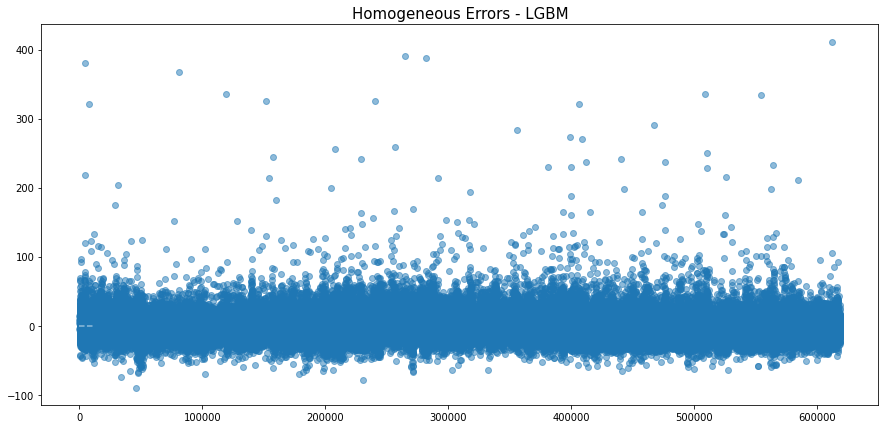

In [203]:
performance = pd.DataFrame({'True Value': y_test,
                            'Prediction': test_pred_org.flatten(),
                            'Error': y_test-test_pred_org.flatten()})


plt.figure(figsize=(15,7))
# Errors
ax_x= performance['True Value']
ax_y= performance['Prediction']
yerr= performance['Error']

plt.scatter(range(len(yerr)), yerr, alpha=.5)
plt.title('Homogeneous Errors - LGBM', size=15);
plt.hlines(y=0, xmin=0, xmax=11000, linestyle='--', color='white', alpha=.5);

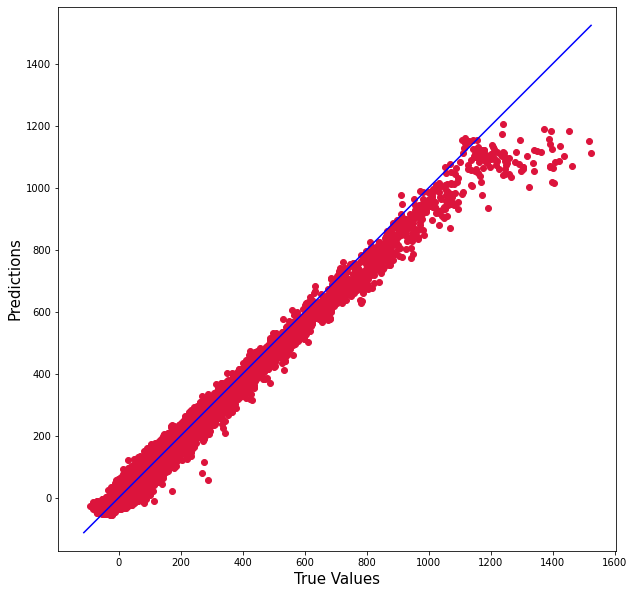

In [204]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, test_pred_org.flatten(), c='crimson')


p1 = max(max(y_test), max(y_val))
p2 = min(min(y_test), min(y_val))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

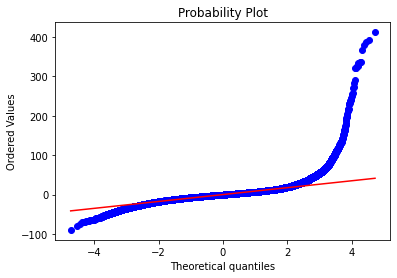

In [205]:
from scipy.stats import probplot
#QQ Plot
probplot(yerr, dist='norm', plot=plt);


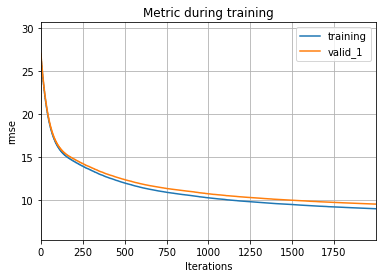

In [158]:
lgb.plot_metric(evals_result, metric='rmse')
plt.show()

In [21]:
'''
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/cecilia.chen/Graphviz/bin/'
'''

'\nimport os\nos.environ["PATH"] += os.pathsep + \'C:/Users/cecilia.chen/Graphviz/bin/\'\n'

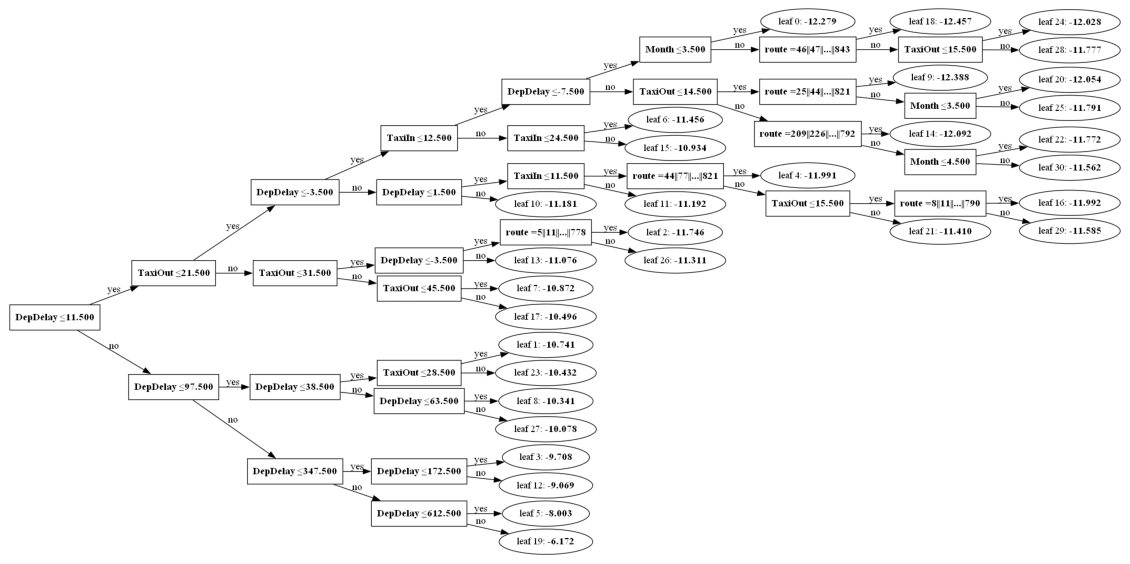

In [159]:
lgb.plot_tree(clf, figsize=(20, 20))
plt.show()

### Prediction on Random Data Samples

In [127]:
X_sample = random_sample.drop(columns_to_drop, axis=1)
y_sample = random_sample['ArrDelay']

In [144]:
X_sample['route'] = X_sample['route'].astype('category')

In [209]:
sample_pred_org = predict_data(clf, X_sample)
prediction_results(y_sample, sample_pred_org)

MAE: 4.83
MSE: 52.73
RMSE: 7.26
R-squared: 0.97


<div style="float: left; margin-right: 10px;">

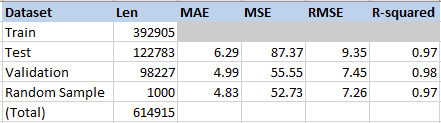
</div>

### Prediction on 2019's Dataset

In [188]:
#read 2019's data
ua_2019 = pd.read_csv('ua_2019.csv')
#remove cancelled and diverted records
ua_2019 = ua_2019[(ua_2019['Cancelled']==0) & (ua_2019['Diverted']==0)]
#concatanate Origin and Dest
ua_2019['route'] = ua_2019['Origin'] + '-' + ua_2019['Dest']

In [214]:
# Add leading 0s if it is less than 4 digits
ua_2019['WheelsOff_time'] = ua_2019['WheelsOff'].apply(lambda x: f'{x // 100:02d}:{x % 100:02d}')
ua_2019['WheelsOn_time'] = ua_2019['WheelsOn'].apply(lambda x: f'{x // 100:02d}:{x % 100:02d}')

# Convert the three or four digits to 'hh:mm' format
ua_2019['WheelsOff_time'] = pd.to_datetime(ua_2019['WheelsOff_time'], format='%H:%M')
ua_2019['WheelsOn_time'] = pd.to_datetime(ua_2019['WheelsOn_time'], format='%H:%M')
   
# Calculate the time difference in minutes
ua_2019['TimeDifferenceMinutes_wheels'] = (ua_2019['WheelsOn_time'] - ua_2019['WheelsOff_time']).dt.total_seconds() / 60
ua_2019['TimeDifferenceMinutes_wheels'] = ua_2019['TimeDifferenceMinutes_wheels'].apply(lambda x: x + 24 * 60 if x < 0 else x)

In [190]:
# Convert column route from type object to category
ua_2019.loc[:,'route'] = ua_2019['route'].astype('category')

In [191]:
# Define X and y
X_ua_2019 = ua_2019[X_train.columns.tolist()]
y_ua_2019 = ua_2019['ArrDelay']

In [210]:
# Predict data and print out prediction results
ua_2019_pred_org = predict_data(clf, X_ua_2019)
prediction_results(y_ua_2019, ua_2019_pred_org)

MAE: 6.29
MSE: 87.37
RMSE: 9.35
R-squared: 0.97


In [236]:
import pickle
#pickle.dump(clf, open('clf_model', 'wb'))
#pickle.dump(pt, open('pt_model', 'wb'))
#loaded_model = pickle.load(open('clf_model', 'rb'))

### Reference

https://www.kaggle.com/code/lasmith/house-price-regression-with-lightgbm

https://neptune.ai/blog/lightgbm-parameters-guide

https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

https://www.datasciencebyexample.com/2023/04/24/lightgbm-regression-complete-example-with-cross-validation-and-early-stop/